# Contents

1. [Topic Extraction](#1.-Topic-Extraction)  
    1.1. [Load sample](#1.1.-Load-sample)  
    1.2. [BERTopic](#1.2.-BERTopic)  
    1.3. [Latent Dirichlet Allocation (LDA)](#1.3.-Latent-Dirichlet-Allocation-(LDA))


# **1. Topic Extraction**

The goal of Topic Extraction (or Topic Modeling) is, as the name says, to automatically identify the most meaningul topics that describe the content of a document, toghether with the most representative keywords for each topic. This is a crucial task in our pipeline, because we want to know what politicians talk about, i.e. what are the possible axis that construct an opinion. For this, we will test two popular tools for topic extraction: **BERTopic** and **LDA**.

In [ ]:
!pip install -U numpy
!pip install pyldavis
!pip install bertopic

# !pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan
# !pip install --upgrade tbb

     |████████████████████████████████| 15.7 MB 5.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 15.7 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=8f91a7d1a0148d38f5bc9d8315f95b7fb2556069f3bf00c7ebfcc100b6d1a439
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 

     |████████████████████████████████| 57 kB 2.6 MB/s 
     |████████████████████████████████| 6.4 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 13.2 MB 19.4 MB/s 
     |████████████████████████████████| 3.1 MB 46.1 MB/s 
     |████████████████████████████████| 3.3 MB 36.3 MB/s 
     |████████████████████████████████| 1.2 MB 36.2 MB/s 
     |████████████████████████████████| 59 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 39.3 MB/s 
     |████████████████████████████████| 636 kB 42.9 MB/s 
     |████████████████████████████████| 1.1 MB 32.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311997 sha256=c86478935602ec07ec2bb5c4f4970d81a8a81f225cb89370d576566f82fa2f82
  Stored in director

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## 1.1. Load sample

In [ ]:
import pandas as pd

To load the datasets and execute the notebook, add a shortcut in MyDrive to [this folder](https://drive.google.com/drive/folders/1lvLMyLd9I3xoRwfghdVOgkTR4hKr76Vn?usp=sharing).

In [ ]:
# Get a preprocessed sample of the dataset, filtered only for quotes of 
# US modern politicians (cfr Data_Wrangling.ipynb)
samplepath_processed = '/content/drive/MyDrive/ADA/Sample/quotes-2020-sample.parquet.gzip'
df = pd.read_parquet(samplepath_processed)
print('Loaded %d sample quotations.'%len(df))

In [ ]:
df.head(5)

## 1.2. BERTopic

**BERTopic** is an algorithm for topic extraction that builds on top of [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), a pretrained language representation model based on [transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) developed by Google and quickly becomed extremely popular for in the NLP community [[1]](https://arxiv.org/abs/1810.04805). 

BERTopic uses BERT to embed documents and then applies sequentially [UMAP](https://umap-learn.readthedocs.io/en/latest/), to reduce the dimensionality, and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/), to cluster semantically similar documents (i.e. create topics). Finally, topic representation is constructed with [c-TF-IDF](https://github.com/MaartenGr/cTFIDF).

The algorithm pipeline is showed schematically below [[2]](https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.html).

<img src="https://maartengr.github.io/BERTopic/tutorial/algorithm/algorithm.png" width="700" height="600"/>

© Maarten Grootendorst 2021

In [ ]:
import time
from bertopic import BERTopic
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

Let's fit BERTopic to our sample, and predict the main topic of each quote. We will set the number of topics parameter of the model as 'auto', so that BERTopic automatically reduce topics with a high similarity.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

We can now see what are the first (in terms of quotes belonging to them) topics and get an idea of which words are associated to them. 

In [ ]:
# Get info about the first 10 extracted topics
topic_model.get_topic_info().head(10)

In [ ]:
topic_model.visualize_barchart(top_n_topics=9, width=800, height=800)

Note: BERTopic interactive outputs are only visible if the notebook has an active runtime. So, to allow consulting the notebook without executing it (e.g. from GitHub), we will show the outputs as static images

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/ADA/Images/barchart.png')

Intuitively, almost all these topics make sense in the context of US political debate and are easly human-intepretable: Education, basketball, Nancy Pelosi, banks, housing, Iran, Donald Trump, racism. Note that the topic -1 refers to all outliers and unmeaningful words, and contains almost half of the quotes.

In [ ]:
topic_model.get_topic_info().tail(10)

Despite having a small amount of quotes for each, also the last (i.e. those with a fewest amount of quotes) topics seem to make sense.

In addition, we can visualize spacially the inter-topic distance.



In [ ]:
topic_model.visualize_topics()

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/intertopic_distance_BERTopic.png')

This shows how correlated topics nicely cluster toghether. For example:
- Cluster all to the right of IV quadrant (candidates to the last elections)
  - Topic 7: trump | donald | president
  - Topic 24: bernie | sanders | progressive
  - Topic 25: biden | joe | candidate
  - Topic 59: bloomberg | bloombergs
- Cluster in bottom left of III quadrant (covid)
  - Topic 19: covid19 | covid | disease
  - Topic 20: virus | spread | spreading
  - Topic 16: coronavirus | health | threat
  - Topic 11: testing | test | labs
  - Topic 30: ventilators | beds | ventilator



On the other hand, a lot of topics are clustered toghether despite being apparently unrelated, and the reason is not immediately clear.


It is interesting to see that numerous quotations are related to news events or transient topics such as Iran nuclear deal, COVID, the 2020 election or Hillary Clinton's email affair. Such topics are dominant during a short time frame, but later lose most of their influence.

In [ ]:
topics_over_time = topic_model.topics_over_time(df.quotation, topics[0], df.date, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/topics_over_time.png')

From these topics, we can also generate word clouds. We will label each row with a topic and generate a word cloud aggregating all the quotes belonging to a certain topic. Before, we will remove some stop words from the sentences, but it is still likely that we will find a lot of useless words.

In [ ]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')


In [ ]:
df['topics'] = topics[0]
df_topics = df[df['topics'] != -1]
df_topics.head(5)

In [ ]:
def topic_wordcloud(topic, df):
  '''
  build wordcloud for the topic given as argument.
  '''
  stp = stopwords.words('english') 
  words = ''.join(df[df['topics'] == topic]['quotation'])
  return WordCloud(width=800, height=560,
                        background_color='white', collocations=False,
                        min_font_size=10, stopwords = stp).generate(words)

In [ ]:
counter = 0
for topic in topic_model.get_topics():
  if topic == -1:
    continue
  plt.figure(figsize=(8, 6), facecolor=None)
  wordcloud = topic_wordcloud(topic, df_topics)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show();
  print("") # Without this line, there is no space between plots
  counter += 1
  if(counter >= 9):
    break

Finally, to evaluate the performance of our model in topic extraction we can use a coherency metric [[3]](https://dl.acm.org/doi/10.1145/2684822.2685324), constructed to investigate how much sentences are _coherent_, i.e. how much they support each other. In short, the closer the coherence score is to 1, the better interpretable the topics are.

In [ ]:
# Snippet adapted from https://github.com/MaartenGr/BERTopic/issues/90#issuecomment-820915389

docs = df.quotation
# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics[0]})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics[0]))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()

In [ ]:
coherence

According to literature, a coherence score of 0.65 is about as good as it gets for current topic extraction models, so the result obtained with BERTopic is promising.  
Next, we turn to LDA, the second topic extraction tool.

## 1.3. Latent Dirichlet Allocation (LDA)

**TODO: Rewrite explanation, textual descriptions, cleaning code**


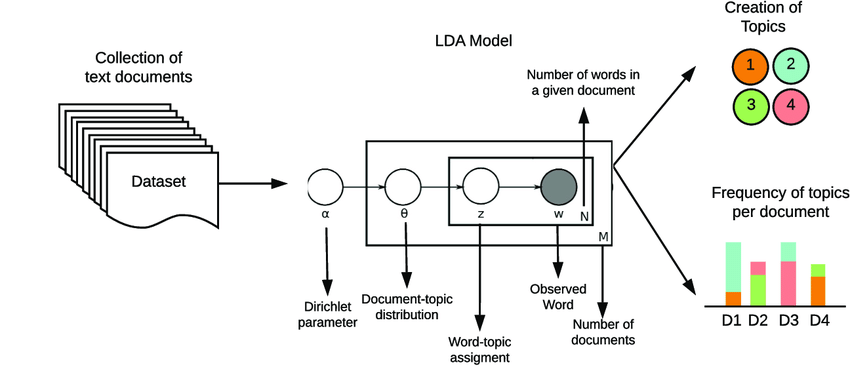


**Figure: overview of LDA model.** Taken from [Buenaño-Fernández et al. (2020).](https://www.researchgate.net/publication/339368709_Text_Mining_of_Open-Ended_Questions_in_Self-Assessment_of_University_Teachers_An_LDA_Topic_Modeling_Approach)



[Latent Dirichlet Allocation (LDA)](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html) is a generative Bayesian probabilistic model, which assumes that each quote in the dataset is a finite mixture over a set of $K$ unobserved topics. A topic is a multimodal distribution over all words in the vocabluary, making certain words to be more likely used within the context of a certain topic.

In particular, LDA assumes that each quote was generated with the following process: 
1. Draw a distribution over the topics, a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) distribution with parameter $\alpha$.
2. For each word in the document, draw a topic from the distribution found in [1], and draw the observed word from the selected topic.  

The parameters of the distributions must be learned from the data, which is  done with statistical learning (usually a Markov Chain Monte Carlo method).

Topic modeling with LDA requires a first step of preprocessing: we need to tokenize and lemmatize our documents. 

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')


In [ ]:
def lemmatize_stemming(text):
    '''
    Lemmatisation and stemming of text.
    '''
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess_lda(text):
    '''
    Tokenize, remove stopwords, lemmatise and stem
    '''
    return [token for token in gensim.utils.simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3]


In [ ]:
# Pre-processing example

test = "It's over Anakin, I have the high ground."
print('Original document: ', test, '\n')

tokens = gensim.utils.simple_preprocess(test)
print('Original document after tokenization: ', tokens, '\n')

print('Preprocessed document after tokenization and stopword removal: ', preprocess_lda(test))

In [ ]:
processed_quotes = df.quotation.map(preprocess_lda)
processed_quotes

Next thing is to convert each document into a word <-> id mapping with a dictionary. 

In [ ]:
dictionary = gensim.corpora.Dictionary(processed_quotes)

In [ ]:
for k,v in dictionary.items():
  print('{} <-> {}'.format(k,v))
  if k>9: break

Then we need to convert the document into a Bag Of Words format.
It is a list of tuples (token_id, token_count) where token_id is the id of the word in the dictionary.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_quotes]
bow_corpus[0]

Then we need to compute the tf-idf representation of our data.

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
# Ignore deprecation warnings as the lib uses some deprecated APIs
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=100, id2word=dictionary, passes=50, workers=2, per_word_topics=True, random_state = 0)
lda_model_tfidf.show_topics()

Now that we have our topics, let's visualize them.

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis

In [ ]:
Image(filename='/content/drive/MyDrive/ADA/Images/intertopic_distance_LDA.png')

How well is our model performing ? 

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_quotes, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

This score of coherence is also quite good, but the topics do not seem as easy to interpret as BERTopic's ones.

# **2. Conclusion**

Comparing BERTopic and LDA, we have found BERTopic to provide very meaningful and easy to interpret topics, and evaluating its performances we found a pretty good coherence score. LDA gave also acceptable results, but the topics are not as easy to interpret and generally seem less meaningful. Also, the coherence score is slightly worse than in BERTopic.

For these reasons, we will use **BERTopic** as our tool for Topic Extraction for the rest of the project.

## 2.1. Feasibility

To evaluate the feasibility of our chosen tool, BERTopic, we will test again the time it takes to evaluate the sentiment on our sample dataset to get a better idea of its performances.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted and predicted topics from %d quotes in %i:%i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Taking almost 4:30 min on 9099 quotes, our filtered dataset of almost 12 milions quotes (US modern politicians) will take almost 100h to run. Arguably, the part which takes the most time is fitting to our model, so we will analyze separately the runtime of fitting and predicting topics.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

In [ ]:
start = time.time()
topics = topic_model.transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

Despite the transform phase being shorter, this is not helping a lot in reducing the total time, even if we only fitted on a portion of our dataset. However, we can do much better if we work with a GPU instead of a CPU!

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Fitted from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

In [ ]:
start = time.time()
topics = topic_model.transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic: Predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

This is indeed much better, as we can just fit the model on a subset of our data (say the 25%, 3 milion quotes) and then predict separately the topics.
Doing so, we would need only 5 hours to fit and less than 4 hours for labeling quotes with topics.

These estimates are based on the assumption that these methods scale near linearly. Since it's not clear from the documentation, we will test ourselves how the time varies with datasets of different sizes.

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
start = time.time()
topics = topic_model.fit_transform(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df), time_elapsed // 60, time_elapsed % 60))

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
df_short = df[:len(df) // 2]
start = time.time()
topics = topic_model.fit_transform(df_short.quotation)
# topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df_short), time_elapsed // 60, time_elapsed % 60))

In [ ]:
topic_model = BERTopic(verbose=True, calculate_probabilities=False, nr_topics='auto')
df_short = df[:len(df) // 10]
start = time.time()
topics = topic_model.fit_transform(df_short.quotation)
# topic_model.fit(df.quotation)
time_elapsed = time.time()-start
print('BERTopic GPU: Fitted and predicted topics from %d quotes in %i:%02i min.'%(len(df_short), time_elapsed // 60, time_elapsed % 60))

We can see clearly that transforming documents to embeddings scales exactly linearly. The other costly step is reducing dimensionality with UMAP, which is known to perform slightly worse than linear, approaching empirically something close to $O(n^{1.14})$ [[3]](https://umap-learn.readthedocs.io/en/latest/benchmarking.html)[[4]](https://github.com/lmcinnes/umap/issues/8#issuecomment-343693402).